# US Immigration Analysis
### Data Engineering Capstone Project

#### Project Summary
The main purpose of the project is to create the data model which will allows to analyze the immigration trends.
For this purpose there needs to be implemented the ETL process which will be executed on a regular basis and will be responsible for cleaning, extracting and loading the data.
The final data model can be used for verifying the correlation between:
 - destination temperature and immigration statistics
 - destination in the U.S and the source country
 - destination in the U.S and the source climates
 - arrival month and number of immigrants

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 1: Scope the Project and Gather Data

#### Scope 
The end solution will make use of the Airflow workflow system which will call all the ETL stages on monthly basis.
For processing (cleaning/transforming) the immigration data there will be used the Apache Spark.
The Apache Spark output will be saved into the S3 buckets.
Finally, the saved data will be loaded into the Redshift cluster for the business analytics queries.

![ETL Architecture](https://lucid.app/publicSegments/view/9943301e-f97d-4cfa-b0df-0ee1a3ec45ab/image.png)

#### Describe and Gather Data 
The project will be based on the immigration dataset as a primary dataset and supplementary datasets like demographics, temperatures and aircodes.

 - **Immigration to the United States** ([source](https://travel.trade.gov/research/reports/i94/historical/2016.html))
 - U.S. city demographics ([source](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/information/))
 - Airport codes ([source](https://datahub.io/core/airport-codes#data))
 - Temperatures ([source](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data))
 
This project will use the star schema with immigration as the fact table, whereas the other datasets serve as dimensions.

### Step 2: Explore and Assess the Data
#### Data preparation
To simplify and speed up the analysis part for the large dataset files there were created sample files with 10,000 records.
Additionally, the data analysis is carried out in Pandas rather than in PySpark, but the final ETL process is implemented in PySpark.
All the analyzed data are provided in the /data directory attached to this notebook (the sample files has _sample prefix):
- immigration_sample.cvs - generated from file **i94_apr16_sub.sas7bdat** (sparkDF.sample(False, 0.01).limit(10000))
- us-cities-demographics.csv - provided by the Udacity
- airport-codes_csv.csv - provided by the Udacity
- temperature_sample.csv - generated from file GlobalLandTemperaturesByCity.csv (pandasDF.sample(10000))

To validate the immigration dataset there were created following dictionaries from udacity provided **I94_SAS_Labels_Descriptions.SAS** file:
- country_codes.csv - list of valid country codes for birth and residence country column validation
- us_ports.csv - list of valid us port codes for us port column validation
- us_states.csv - list of valid us state codes for us state column validation
- visa_modes.csv - list of visa modes identifiers for visa mode column validation

and dictionaries from external sources:
- visat_types.csv - list of visa types [source](https://www.trade.gov/visitor-arrivals-program-i-94-data).


#### Explore the Data 
To understand the data there was done the exploratory data analysis (EDA). The results of this analysis allowed to judge the data quality and drive the conceptual data model creation.

#### Cleaning Steps
The cleaning process were dependent on the dataset, thus not all the steps were executed for each dataset.
Generally, the process was divided into steps which were carried out in the following order:
- **rename columns** (first steps in which columns are renamed to more meaningful names which are used later through the process)
- **remove missing features/values** (the features (columns) which have more than 50% missing values are removed from the final dataset)
- **validate data** (the columns values are validated against provided dictionaries)
- **remove duplicates** (the rows which are duplicated are removed)
- **cast data** (the column types are casted to more suitable data types (ex. after loading data some column types are assigned float type were can be represented by the integer type))
- **convert data** (this step is applied to all columns where data values needs processing which cannot be achieved by casting (ex. converting int date type to datetime data type))

The data processing order is important since the first steps (empty features, data validation, duplicated values) removes unnecessary data, and then the data manipulation steps works on smaller dataset.

![Cleaning steps](https://app.lucidchart.com/publicSegments/view/6b8baf08-a6dc-4e08-a3d4-10b11f769068/image.png "Cleaning steps")

#### Immigration data

This dataset comes from the US National Tourism and Trade Office. An I-**94** known as the Arrival-Departure Record Card is confirmation that a foreign national was allowed entry into the country. It keeps track of during any entries into the US in any nonimmigrant visa status.
This dataset contains the below information.
The 'source column' is the column name get from the original dataset and the 'RenameTo column' is the column which will be used in the rename step.

| Source column | RenameTo column               | Description                                                                                      |
|---------------|----------------------------------|--------------------------------------------------------------------------------------------------|
| CICID         |  Id                              | CICID is a unique number for the immigrants                                                      |
| I94YR         |  year                            | 4 digit year                                                                                     |
| I94MON        |  month                           | Numeric month                                                                                    |
| I94CIT        |  birth_country                   | country of citizenship                                                                           |
| I94RES        |  residence_country               | country of residence                                                                             |
| I94PORT       |  port                            | 3 character code of US city destination                                                          |
| ARRDATE       |  arrival_date                    | Arrival date in the US                                                                           |
| I94MODE       |  arrival_type                    | 1 digit travel code (1 = 'Air', 2 = 'Sea', 3 = 'Land', 9 = 'Not reported')                       |
| I94ADDR       |  us_state                        | Address where the immigrants resides in US state                                                 |
| DEPDATE       |  departure_date                  | Departure Date from the US                                                                       |
| I94BIR        |  person_age                      | Respondent age  in Years                                                                         |
| I94VISA       |  visa_mode                       | Visa codes                                                                                       |
| COUNT         |  count                           | Used for summary statistics                                                                      |
| DTADFILE      |  added_date                      | Character Date Field - Date added to I-94 Files - CIC does not use                               |
| VISAPOST      |  visa_issue_department           | Department of State where where Visa was issued - CIC does not use                               |
| OCCUP         |  occupation                      | Occupation that will be performed in US  - CIC does not use                                      |
| ENTDEPA       |  arrival_flag                    | Arrival Flag - admitted or paroled into the US - CIC does not use                                |
| ENTDEPD       |  departure_flag                  | Departure Flag - Departed, lost I-94 or is deceased - CIC does not use                           |
| ENTDEPU       |  update_flag                     | Update Flag - Either apprehended, overstayed, adjusted to perm residence - CIC does not use      |
| MATFLAG       |  match_arrival_departure_flag    | Match flag - Match of arrival and departure records                                              |
| BIRYEAR       |  birth_year                      | 4 digit year of birth                                                                            |
| DTADDTO       |  allowed_stay_date               | Character Date Field - Date to which admitted to U.S. (allowed to stay until) - CIC does not use |
| GENDER        |  gender                          | Non-immigrant sex                                                                                |
| INSNUM        |  ins_number                      | INS number                                                                                       |
| AIRLINE       |  airline                         | Airline used to arrive in U.S                                                                    |
| ADMNUM        |  admission_number                | Admission number                                                                                 |
| FLTNO         |  flight_number                   | Flight number of airline used to arrive in US                                                    |
| VISATYPE      |  visa_type                       | Type of visa which one owns                                                                      |

##### Data source
This is the main dataset with file for each month of 2016 year saved in [SAS file format](https://github.com/saurfang/spark-sas7bdat).</br>
The average files size is about 500MB and contains 3 milion records.

In [2]:
# import required packages
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

In [3]:
# read the immigration data sample
df_im = pd.read_csv('data/immigration_sample.csv')

In [4]:
# show head data
df_im.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,150.0,2016.0,4.0,103.0,103.0,NEW,20545.0,1.0,NY,20553.0,...,NaN,M,1969.0,06292016,M,NaN,LH,5.543658e+10,00402,WT
1,239.0,2016.0,4.0,103.0,103.0,NYC,20545.0,1.0,NY,20551.0,...,NaN,M,1993.0,06292016,F,NaN,AB,5.542191e+10,07450,WT
2,310.0,2016.0,4.0,103.0,103.0,NYC,20545.0,1.0,NY,20560.0,...,NaN,M,1992.0,06292016,NaN,NaN,OS,5.542632e+10,00087,WT
3,381.0,2016.0,4.0,103.0,103.0,MIA,20545.0,1.0,FL,20553.0,...,NaN,M,1955.0,06292016,M,NaN,OS,5.542856e+10,00097,WT
4,392.0,2016.0,4.0,103.0,103.0,MIA,20545.0,1.0,FL,20559.0,...,NaN,M,1976.0,06292016,F,NaN,OS,5.543319e+10,00097,WT


In [5]:
# rename columns
df_im.rename(columns= {'cicid': 'Id',  
          'i94yr': 'year' ,  
          'i94mon': 'month' ,  
          'i94cit': 'birth_country' ,  
          'i94res': 'residence_country' ,  
          'i94port': 'port' ,  
          'arrdate': 'arrival_date' ,  
          'i94mode': 'arrival_type' ,  
          'i94addr': 'us_state' ,  
          'depdate': 'departure_date' ,  
          'i94bir': 'person_age' ,  
          'i94visa': 'visa_mode' ,  
          'count': 'ccount',
          'dtadfile': 'added_date' ,  
          'visapost': 'visa_issue_department' ,  
          'occup': 'occupation' ,  
          'entdepa': 'arrival_flag' ,  
          'entdepd': 'departure_flag' ,  
          'entdepu': 'update_flag' ,  
          'matflag': 'match_arrival_departure_flag' ,  
          'biryear': 'birth_year' ,  
          'dtaddto': 'allowed_stay_date' ,  
          'gender': 'gender' ,  
          'insnum': 'ins_number' ,  
          'airline': 'airline' ,  
          'admnum': 'admission_number' ,  
          'fltno': 'flight_number' ,  
          'visatype': 'visa_type'},  
         inplace=True)

df_im.dtypes

Id                              float64
year                            float64
month                           float64
birth_country                   float64
residence_country               float64
port                             object
arrival_date                    float64
arrival_type                    float64
us_state                         object
departure_date                  float64
person_age                      float64
visa_mode                       float64
ccount                          float64
added_date                        int64
visa_issue_department            object
occupation                       object
arrival_flag                     object
departure_flag                   object
update_flag                      object
match_arrival_departure_flag     object
birth_year                      float64
allowed_stay_date                object
gender                           object
ins_number                      float64
airline                          object


occupation - 100%
update_flag - 100%
ins_number - 100%
visa_issue_department - 62%
gender - 15%
departure_date - 4%
departure_flag - 4%
match_arrival_departure_flag - 4%
us_state - 3%


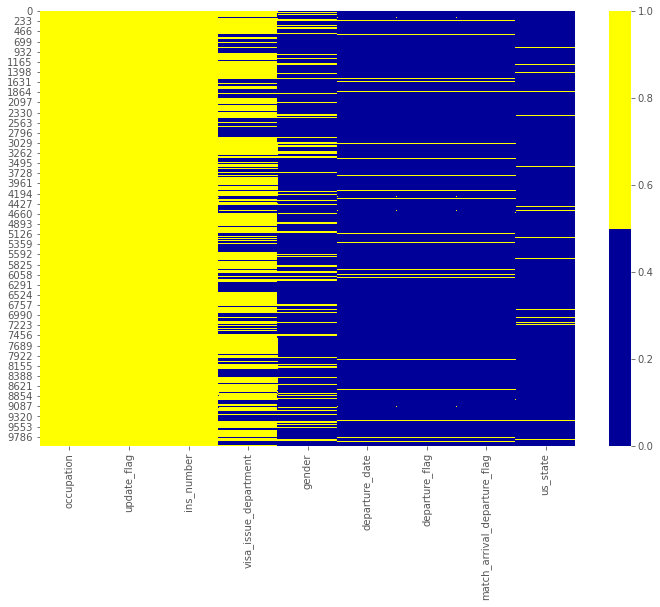

In [6]:
# Visualize the missing data using the heatmap
# the concept was adopted from the article: https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d
def showMissingDataHeatMap(df):
    pct_dict = []
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        pct = round(pct_missing*100)
        if pct > 0:
            pct_dict.append((col, pct))

    pct_dict.sort(key=lambda x:x[1], reverse=True)
    for key, val in pct_dict:
        print('{} - {}%'.format(key, val))

    cols_with_missing = [x[0] for x in pct_dict]
    # heat map for columns with missing values sorted by missing pct vals
    colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
    sns.heatmap(df[cols_with_missing].isnull(), cmap=sns.color_palette(colours))

showMissingDataHeatMap(df_im)

In [7]:
# Remove features which have more that 50% of missing values.
# From the above we see that following features met above condition: occupation, update_flag, ins_number, visa_issue_department
df_im.drop(columns=['occupation', 'update_flag', 'ins_number', 'visa_issue_department'], inplace=True)

In [8]:
# validate against 'country code' dictionary
df_dict_country_codes = pd.read_csv('data/dicts/country_code.csv')
count_before = df_im.shape[0]
res_country_filter = df_im['residence_country'].isin(df_dict_country_codes['code'])
birt_country_filter = df_im['birth_country'].isin(df_dict_country_codes['code'])
df_im = df_im[res_country_filter & birt_country_filter]         
print('Removed rows after residence and birth country validation: {}%'.format(((count_before-df_im.shape[0])/10000)*100))

Removed rows after residence and birth country validation: 11.04%


In [9]:
# validate against 'us port' dictionary
df_dict_port_codes = pd.read_csv('data/dicts/us_port.csv')
count_before = df_im.shape[0]
port_filter = df_im['port'].isin(df_dict_port_codes['code'])
df_im = df_im[port_filter]         
print('Removed rows after port validation: {}%'.format(((count_before-df_im.shape[0])/10000)*100))

Removed rows after port validation: 3.5700000000000003%


In [10]:
# validate against 'us states' dictionary
df_dict_states_codes = pd.read_csv('data/dicts/us_state.csv')
count_before = df_im.shape[0]
state_filter = df_im['us_state'].isin(df_dict_states_codes['code'])
df_im = df_im[state_filter]         
print('Removed rows after us state validation: {}%'.format(((count_before-df_im.shape[0])/10000)*100))

Removed rows after us state validation: 3.65%


In [11]:
# validate against 'visa modes' dictionary
df_dict_visa_modes = pd.read_csv('data/dicts/visa_mode.csv')
count_before = df_im.shape[0]
visa_mode_filter = df_im['visa_mode'].isin(df_dict_visa_modes['id'])
df_im = df_im[visa_mode_filter]         
print('Removed rows after visa mode validation: {}%'.format(((count_before-df_im.shape[0])/10000)*100))

Removed rows after visa mode validation: 0.0%


In [12]:
# validate against 'visa types' dictionary
df_dict_visa_types = pd.read_csv('data/dicts/visa_type.csv')
count_before = df_im.shape[0]

# normalize data
df_im['visa_type'] = df_im['visa_type'].str.strip().str.upper()

visa_type_filter = df_im['visa_type'].isin(df_dict_visa_types['code'])
df_im = df_im[visa_type_filter]    

print('Removed rows after visa type validation: {}%'.format(((count_before-df_im.shape[0])/10000)*100))

Removed rows after visa type validation: 0.0%


In [13]:
# validate against 'arrival types' dictionary
df_dict_arrival_types = pd.read_csv('data/dicts/arrival_type.csv')
count_before = df_im.shape[0]

arrival_type_filter = df_im['arrival_type'].isin(df_dict_arrival_types['id'])
df_im = df_im[arrival_type_filter]    

print('Removed rows after arrival type validation: {}%'.format(((count_before-df_im.shape[0])/10000)*100))

Removed rows after arrival type validation: 0.0%


In [14]:
# cast immigration float data types to int
im_column_names_to_int = ['Id', 'year', 'month', 'birth_country', 'residence_country',
                          'arrival_date', 'arrival_type', 'departure_date', 'person_age', 'visa_mode',
                          'ccount', 'added_date', 'birth_year']
for col in  im_column_names_to_int:
    df_im[col] = pd.to_numeric(df_im[col], errors='coerce', downcast='integer')
    
df_im[im_column_names_to_int].dtypes

Id                     int32
year                   int16
month                   int8
birth_country          int16
residence_country      int16
arrival_date           int16
arrival_type            int8
departure_date       float64
person_age              int8
visa_mode               int8
ccount                  int8
added_date             int32
birth_year             int16
dtype: object

In [15]:
# convert int to date type (part 1)
from datetime import datetime
def convert_to_datetime(val):
    return pd.to_timedelta(val, unit='d', errors='coerce') + datetime(1960, 1, 1)

im_column_names_convered_to_date = ['arrival_date', 'departure_date']

for col in im_column_names_convered_to_date:
    df_im[col] = df_im[col].apply(convert_to_datetime)
    
df_im[im_column_names_convered_to_date].dtypes

arrival_date      datetime64[ns]
departure_date    datetime64[ns]
dtype: object

In [16]:
# convert int to date type (part 2)
def parse_to_datetime(val):
    return pd.to_datetime(val, format='%Y%m%d', errors='coerce')

im_column_names_parsed_to_date = ['added_date']

for col in im_column_names_parsed_to_date:
    df_im[col] = df_im[col].apply(parse_to_datetime)
    
df_im[im_column_names_parsed_to_date].dtypes

added_date    datetime64[ns]
dtype: object

In [17]:
df_im.dtypes

Id                                       int32
year                                     int16
month                                     int8
birth_country                            int16
residence_country                        int16
port                                    object
arrival_date                    datetime64[ns]
arrival_type                              int8
us_state                                object
departure_date                  datetime64[ns]
person_age                                int8
visa_mode                                 int8
ccount                                    int8
added_date                      datetime64[ns]
arrival_flag                            object
departure_flag                          object
match_arrival_departure_flag            object
birth_year                               int16
allowed_stay_date                       object
gender                                  object
airline                                 object
admission_num

In [18]:
df_im.shape

(8174, 24)

#### Demograhics dataset

This dataset consist of data about the demographics of all US cities and census-designated places with a population greater or equal to 65,000 and comes from the US Census Bureau's 2015 American Community Survey ([source](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/information/)).

This dataset contains following information:
- City
- State
- Median Age
- Male Population
- Female Population
- Total Population
- Number of Veterans
- Foreign-born
- Average Household Size
- State Code
- Race
- Count (race population count in the given city)

##### Data source
The datasest is saved in single CSV file.<br>
The file size is 249kB and it contains about 3,000 records.

In [19]:
# read the immigration data sample
df_demo = pd.read_csv('data/us-cities-demographics.csv', sep=";")

In [20]:
# show head data
df_demo.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [21]:
# rename columns
df_demo.rename(columns= {'City': 'city',
        'State': 'state_name',
        'Median Age': 'median_age',
        'Male Population': 'male_population',
        'Female Population': 'female_population',
        'Total Population': 'total_population',
        'Number of Veterans': 'veterans_count',
        'Foreign-born': 'foreigners_count',
        'Average Household Size': 'avg_household_size',
        'State Code': 'state_code',
        'Race': 'race',
        'Count': 'race_count'},
    inplace=True)

df_demo.shape

(2891, 12)

avg_household_size - 1%


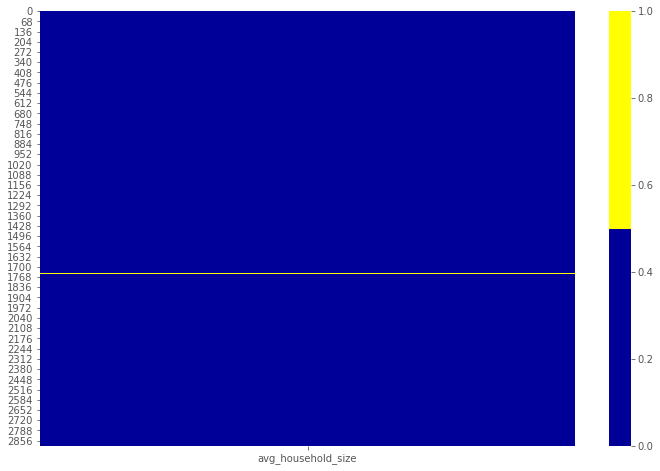

In [22]:
# missing data visualization
showMissingDataHeatMap(df_demo)

In [23]:
# validate against 'us states' dictionary
count_before = df_demo.shape[0]
state_filter = df_demo['state_code'].isin(df_dict_states_codes['code'])
df_demo = df_demo[state_filter]         
print('Removed rows after us state validation: {}%'.format(((count_before-df_demo.shape[0])/10000)*100))

Removed rows after us state validation: 0.0%


In [24]:
# duplicated values
count_before = df_demo.shape[0]
print(df_demo[df_demo.duplicated(['city', 'state_name', 'race'])])

Empty DataFrame
Columns: [city, state_name, median_age, male_population, female_population, total_population, veterans_count, foreigners_count, avg_household_size, state_code, race, race_count]
Index: []


#### Airport codes dataset
This dataset contains the list of all airport codes from around the world. Some of the columns contain attributes identifying airport locations, other codes (IATA, local if exist) that are relevant to identification of an airport. This dataset was downloaded from public domain source http://ourairports.com/data/ who compiled this data from multiple different sources ([source](https://datahub.io/core/airport-codes#data)).

This dataset contains following information:
- ident
- type
- name
- elevation_ft
- continent
- iso_country
- iso_region
- municipality
- gps_code
- iata_code
- local_code
- coordinates

##### Data source
This dataset is saved in single CSV file.</br>
The file size is 5MB and contains about 55,000 records.

In [25]:
# read the immigration data sample
df_air = pd.read_csv('data/airport-codes.csv')

In [26]:
# show head data
df_air.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [27]:
df_air['local_code'].describe()

count     28686
unique    27436
top         AMA
freq          5
Name: local_code, dtype: object

iata_code - 83%
continent - 50%
local_code - 48%
gps_code - 26%
elevation_ft - 13%
municipality - 10%


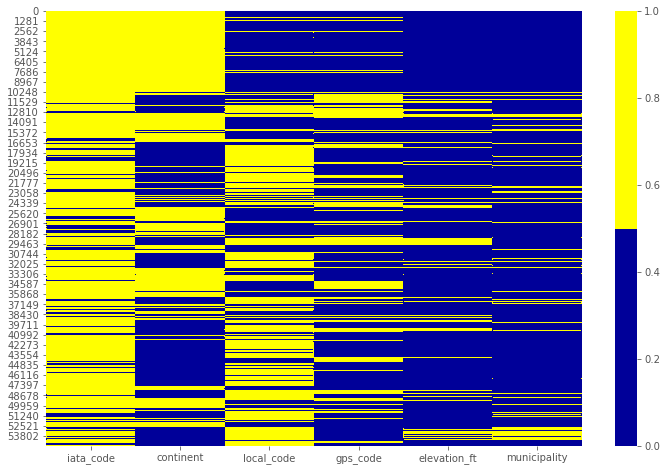

In [28]:
showMissingDataHeatMap(df_air)

continent - 100%
iata_code - 91%
gps_code - 8%
local_code - 7%
elevation_ft - 1%


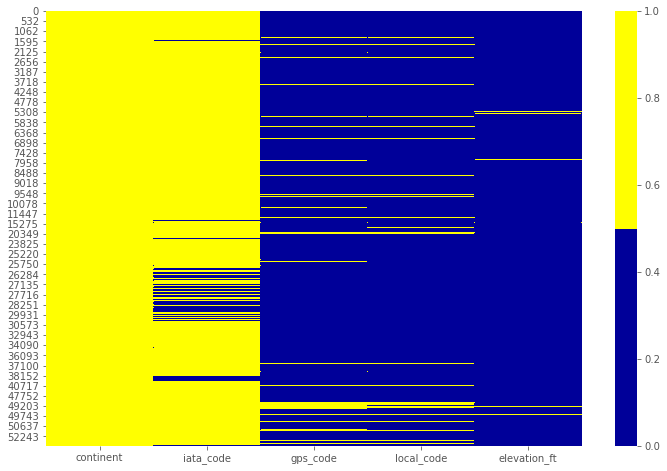

In [29]:
showMissingDataHeatMap(df_air[df_air['iso_country'] == 'US'])

In [30]:
# Remove features which have more that 50% of missing values.
# From the above we see that following features met above condition: occupation, update_flag, ins_number, visa_issue_department
df_air.drop(columns=['iata_code'], inplace=True)

In [31]:
# Drop duplicates
count_before = df_air.shape[0]
df_air = df_air.drop_duplicates(subset=['type', 'name', 'iso_region'], keep='last')
print('Removed duplicated for type and name columns: {}%'.format(((count_before-df_air.shape[0])/10000)*100))

Removed duplicated for type and name columns: 4.97%


#### Temperature dataset
Historical temperature dataset starting from the year 1750 and finishing in the year 2013 ([source](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)).

This dataset contains following information:
- Date
- AverageTemperature
- AverageTemperatureUncertainty
- City
- Country
- Latitude
- Longitude

##### Data source
The dataset is saved in single CSV file.<br/>
The file size is 500MB and it contains about 8,000,000 records.

In [32]:
# read the immigration data sample
df_temp = pd.read_csv('data/temperature_sample.csv')

In [33]:
# show head data
df_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1850-03-01,2.527,3.036,Haarlem,Netherlands,52.24N,5.26E
1,2000-02-01,6.024,0.139,Gloucester,United Kingdom,52.24N,2.63W
2,1922-08-01,22.436,0.651,Manta,Ecuador,0.80S,81.16W
3,1889-07-01,25.044,0.547,Badajoz,Spain,39.38N,6.24W
4,1854-08-01,33.008,1.561,Larkana,Pakistan,28.13N,68.18E


In [34]:
df_temp.rename(columns= 
          {'dt': 'date',  
           'AverageTemperature': 'avg_temp',
           'AverageTemperatureUncertainty': 'avg_temp_uncertanity',
           'City': 'city',
           'Country': 'country',
           'Latitude': 'latitude',
           'Longitude': 'longitude'
          },  
         inplace=True)

In [35]:
df_temp.dtypes

date                     object
avg_temp                float64
avg_temp_uncertanity    float64
city                     object
country                  object
latitude                 object
longitude                object
dtype: object

avg_temp - 4%
avg_temp_uncertanity - 4%


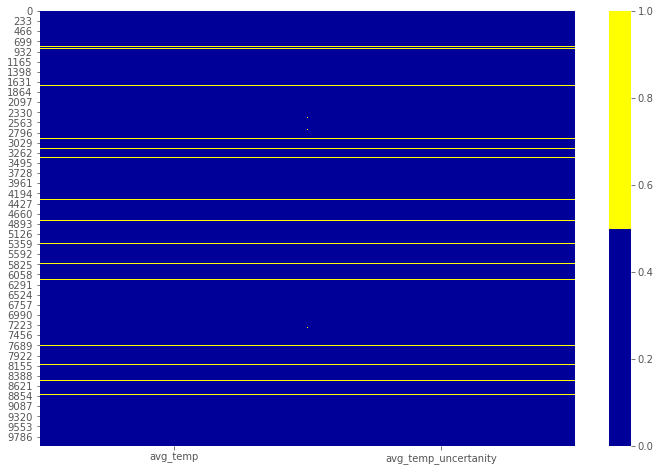

In [36]:
showMissingDataHeatMap(df_temp)

In [37]:
# Drop missing values for AverageTemperature
count_before = df_temp.shape[0]
df_temp = df_temp.dropna(subset=['avg_temp'])
print('Removed rows with missing values in column AverageTemperature: {}%'.format(((count_before-df_temp.shape[0])/10000)*100))

Removed rows with missing values in column AverageTemperature: 4.33%


### Step 3: Define the Data Model
The source data consists of the following datasets:
- immigration
- demographics
- airports
- temperature

![Datasets](https://app.lucidchart.com/publicSegments/view/b22781a6-a7e7-4a0e-8a24-0c1fbabe12c7/image.png)

additional data are extracted from the udacity provided [SAS description file](work/data/I94_SAS_Labels_Descriptions.SAS):
- country codes
- us ports
- us states
- visa modes

and external sources:
- visa types

#### 3.1 Conceptual Data Model
In the project there was adopted star schema with immigration dataset used for the fact table.
To simplify the analysis the columns in the fact table (dim_immigration) can be grouped into following classes:
- report (year, month)
- person (country, gender, age, admission number, added date)
- arrival (port, state, date, type, visa, airline, flight)
- departure (date)

For the fact table there were created following dimension tables:
- state (dim_us_state)
- port (dim_us_airport)
- date (dim_date)
- country (dim_country)
- arrival type (dim_arrival_type)
- visa mode (dim_visa_mode)
- visa type (dim_visa_type)

##### Dimension tables

**dim_us_state** - created by pivoting the demographics dataset by race column and aggregating the data, additionally there were added percentage columns to simplify analitical queries.<br/>
**dim_us_ports** - created from subset of the airport dataset as a result of extracting only airports which belong to US.<br/>
**dim_date** - created from all the date columns from immigration dataset (added_date, arrival_date, allowed_stay_date, departure_date)<br/>
**dim_country** - created by merging the data from 'country codes' dictionary with temperature data set. For the temperature dataset there was used much smaller dataset already aggregated by the country (for the analysis there was used GlobalLandTemperaturesByCity.csv dataset (500MB) for the implementation there was used its much smaller (20MB) already aggregated by country version GlobalLandTemperaturesByCountry.csv)<br/>

![Conceptual model](https://app.lucidchart.com/publicSegments/view/51c3d86d-2745-4d07-97e9-08a4ed962a88/image.png)

#### 3.1 Physical Data Model

Physical data model was created for the Amazon Redshift. 
There were defined following constraints:
- primary keys
- foreign keys
- unique columns
- optional/required columns

![Immigration data model](https://app.lucidchart.com/publicSegments/view/f7f609fa-5cb5-4582-8ef8-8c8708a7e424/image.png "Immigration data model")

#### 3.2 Mapping Out Data Pipelines
The steps necessary to pipeline the data into the chosen physical data model are divided into the three categories:
- process (raw data is cleaned/transformed and saved into intermediate storage)
- load (cleaned data is loaded to the destination warehouse)
- check (the quality checks are runned on final data)

Since, the dimensions for visa modes, visa types and arrival types are already cleaned and stored in S3 bucket, they are directly loaded into the the warehouse. All other data require prior processing step (cleaned/transformed).

![ETL Process](https://app.lucidchart.com/publicSegments/view/429f080b-5aac-4b2e-acbd-58edf622c70b/image.png "ETL Process")

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
The data pipeline was implemented in the Apache airflow with the following project structure:

The dags folder contain the ETL process which is run on the monthly basis.
<br/>The process_* tasks are executing the SparkSubmitOperator.
<br/>The load_* tasks are executing custom StageToRedshiftOperator which is defined in plugins/operators folder.
<br/>The create_img_db.sql is the final star schema SQL definition file which is run on the Redshfit cluster prior to ETL to create required tables.
<br/>The /tests folder contains the unit tests.
<br/>The /tests/i94project subfolder contains the local input data for the ETL process unit testing (see folder structure below).

<br/>The ETL process operates on the following input data structure :

The stage/input contains all the data that are processed by process_* tasks:
 * i94 immigration data (file per month)
 * airport codes
 * global temperatures
 * us cities demographics

The dicts folder contains all the required dictionaries:
 * arrival type
 * country code
 * us port
 * us state
 * visa mode
 * visa type

#### 4.2 Data Quality Checks

To ensure high quality ETL process there were created unit tests for each of the ETL stages:
* cleaning
* transform
* spark execution

Additionally, for the unit tests there was created local folder structure to mimic the S3 buckets ETL source data.

The quality checks were implemented by custom DataQualityOperator operator.
This operator executes the quality checks which are defined in plugins/helpers/data_quality_checks.json configuration file.

#### 4.3 Data dictionary 
All the dictionaries are included in the folder /airflow/tests/i94project/dicts.
<br/>The final data model description can be found in the conceptual and physcial data model secion.

#### 4.4 Enviroment setup.
The simplify the development the Apache Airflow and Apache Spark were run from the same docker image.
<br/>The development enviroment was created by: 
* downloading the docker airflow docker image: https://hub.docker.com/r/puckel/docker-airflow
* installing the Apache Spark 3.0.1

The final airflow/spark docker image was run with mapped local dag and plugin folder:

#### Step 5: Complete Project Write Up
##### Clearly state the rationale for the choice of tools and technologies for the project.
The Amazon S3 bucket is reliable source of the input data.
The Apache Airflow allows to automate the ETL process and run it on the monthly basis. Moreover, it creates enviroment which is:
 * dynamic
 * built from reusable tasks
 * easily monitored
 * easily backfilled

The Apache Spark allows efficient big data processing and simple scalling.
The Amazon Redshift is opinionated data warehouse and efficient business query processing engine.
##### Propose how often the data should be updated and why.
The data are generated on the monthly basis, thus the DAG configuration is set up accordingly.
##### Write a description of how you would approach the problem differently under the following scenarios: The data was increased by 100x.
The whole process should be moved to Amazon EMR cluster with set auto scalling option.
##### The data populates a dashboard that must be updated on a daily basis by 7am every day.
There should be created new DAG run on the daily basis.
##### The database needed to be accessed by 100+ people.
The redshift cluster should be used with auto scalling option.